In [28]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import math
import scipy.stats as stats
import itertools

In [29]:
# Load AKSI stock dataset
df_aksi = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='AKSI.JK')
df_aksi.set_index('Date', drop=True, inplace=True)
df_aksi.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-04,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-05,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-06,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-07,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0


In [30]:
# Check datatypes
print(df_aksi.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [31]:
# Check missing value
print(df_aksi.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [32]:
# Fill missing value using mean imputation
for i in df_aksi[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_aksi[i].fillna(df_aksi[i].mean(), inplace=True)

print(df_aksi.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


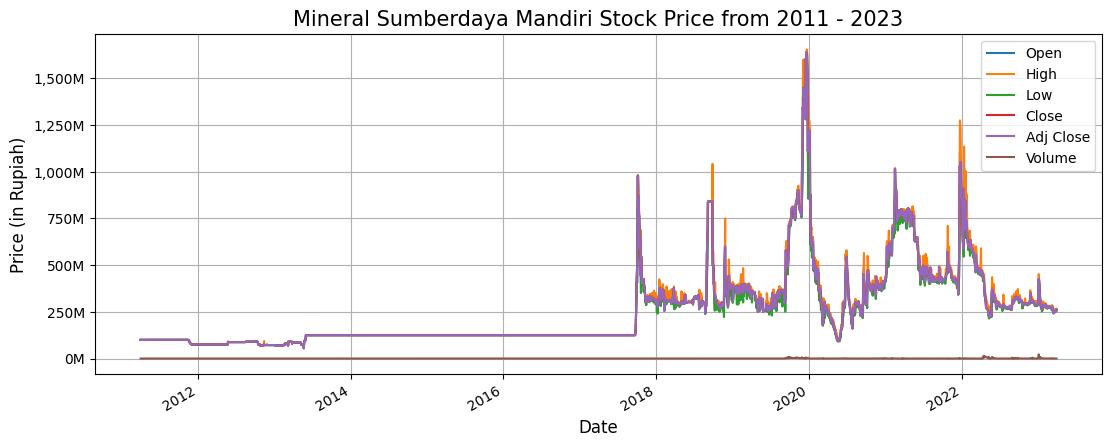

In [33]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_aksi.plot(figsize=(13,5))
plt.title('Mineral Sumberdaya Mandiri Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [34]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_aksi[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [35]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]] 

Testing Scaled:  [[0.43217666]
 [0.40063091]
 [0.49842271]
 [0.4637224 ]
 [0.44164038]]


In [36]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [37]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 5s 64ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 4/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 1s 27ms/step - loss: 9.5031e-04 - val_loss: 0.0022
Epoch 7/10
24/24 [==============================] - 1s 26ms/step - loss: 8.8450e-04 - val_loss: 0.0032
Epoch 8/10
24/24 [==============================] - 1s 30ms/step - loss: 8.8067e-04 - val_loss: 0.0021
Epoch 9/10
24/24 [==============================] - 1s 28ms/step - loss: 7.8475e-04 - val_loss: 0.0019
Epoch 10/10
24/24 [==============================] - 1s 29ms/step - loss: 7.3452e-04 - val_lo

In [38]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 10ms/step
Mean Absolute Error (MAE): 0.0103346
Mean Absolute Percentage Error (MAPE): 0.06599
Root Mean Squared Error (RMSE): 0.01509
Mean Squared Error (MSE): 0.0002278
R-Squared (R2): 0.443131
T-Statistic 0.8716
P-Value 2.880338112118408e-13
Elapsed Time (min): 11.39


7/7 [==============================] - 0s 8ms/step


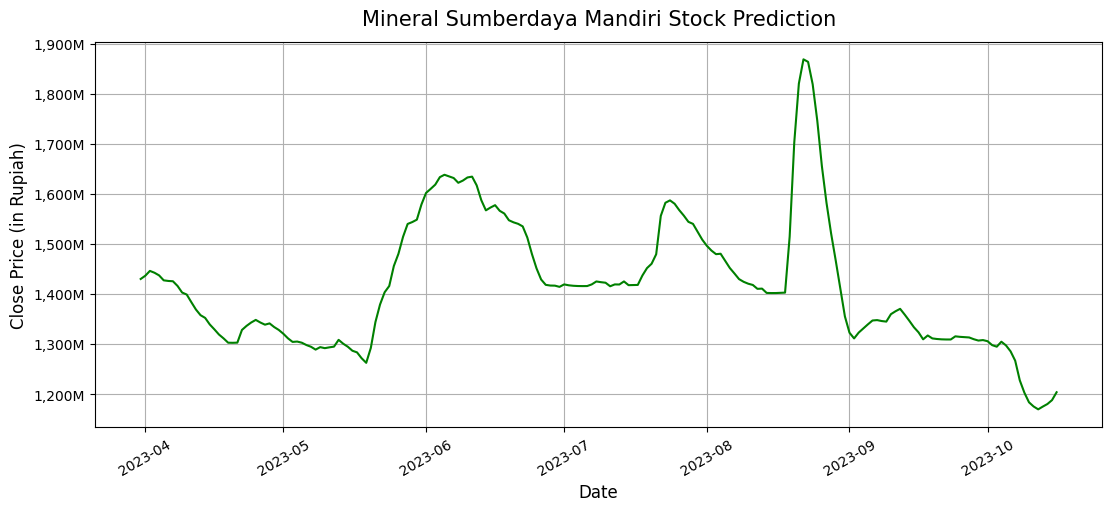

In [39]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [40]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 14s 309ms/step - loss: 0.0045 - val_loss: 0.0113
Epoch 2/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 5s 212ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 4/10
24/24 [==============================] - 5s 210ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 5s 219ms/step - loss: 9.2980e-04 - val_loss: 0.0026
Epoch 6/10
24/24 [==============================] - 5s 230ms/step - loss: 8.9003e-04 - val_loss: 0.0048
Epoch 7/10
24/24 [==============================] - 5s 223ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 6s 232ms/step - loss: 8.8106e-04 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 5s 223ms/step - loss: 8.4821e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 5s 216ms/step - loss: 8.0388e-

In [41]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.0107437
Mean Absolute Percentage Error (MAPE): 0.0688
Root Mean Squared Error (RMSE): 0.01538
Mean Squared Error (MSE): 0.0002364
R-Squared (R2): 0.422024
T-Statistic 0.8854
P-Value 1.9253945226366254e-12
Elapsed Time (min): 63.13


7/7 [==============================] - 0s 45ms/step


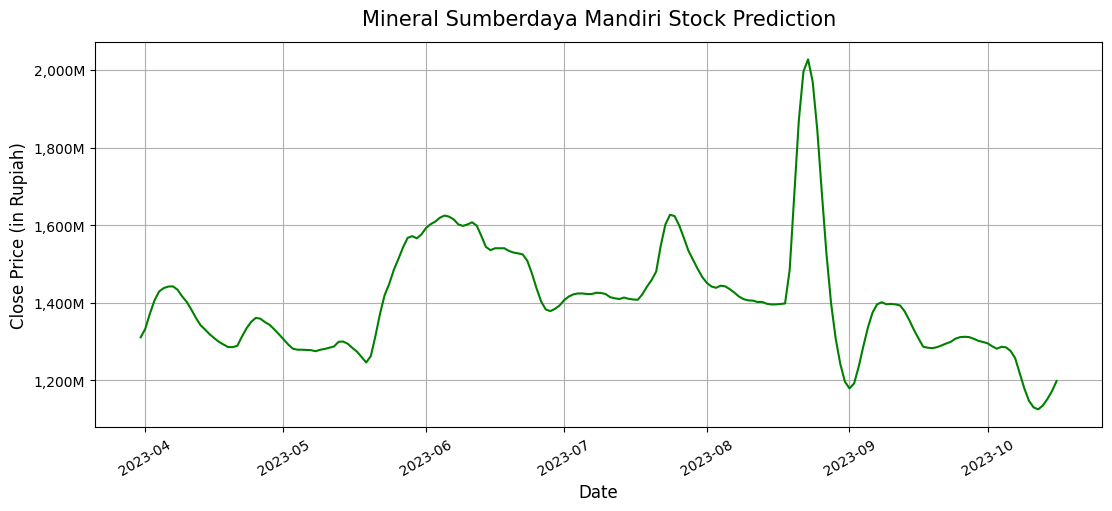

In [42]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [43]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 16s 371ms/step - loss: 0.0186 - val_loss: 0.0735
Epoch 2/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0152 - val_loss: 0.0640
Epoch 3/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0145 - val_loss: 0.0606
Epoch 4/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0142 - val_loss: 0.0575
Epoch 5/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0138 - val_loss: 0.0564
Epoch 6/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0134 - val_loss: 0.0553
Epoch 7/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0128 - val_loss: 0.0539
Epoch 8/10
24/24 [==============================] - 6s 237ms/step - loss: 0.0129 - val_loss: 0.0512
Epoch 9/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0122 - val_loss: 0.0505
Epoch 10/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0120 - val_loss: 0.048

In [44]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.0417831
Mean Absolute Percentage Error (MAPE): 0.26725
Root Mean Squared Error (RMSE): 0.04594
Mean Squared Error (MSE): 0.0021103
R-Squared (R2): -4.15979
T-Statistic 0.6607
P-Value 1.5271002148789823e-21
Elapsed Time (min): 69.8


7/7 [==============================] - 0s 33ms/step


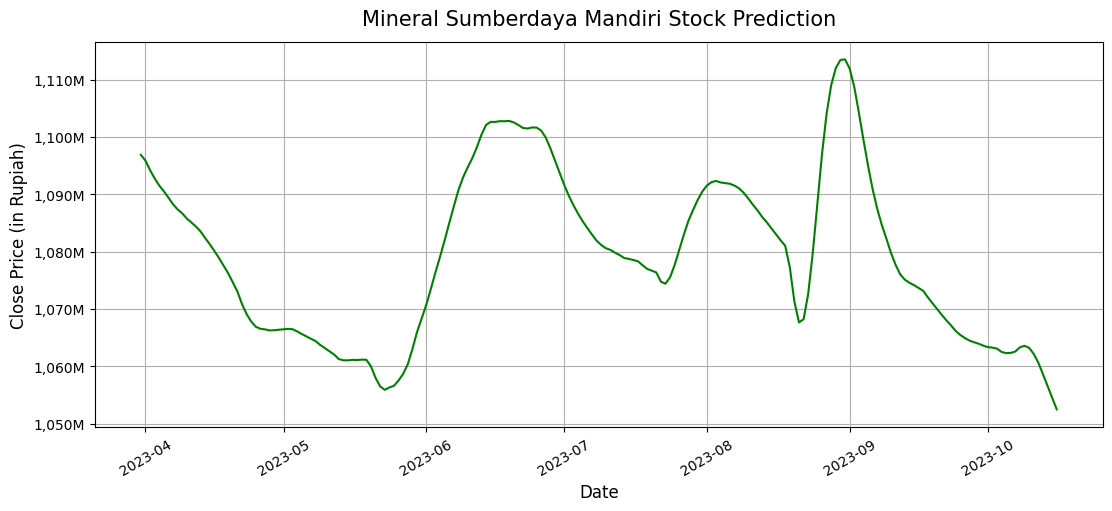

In [45]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [46]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 18s 342ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 2/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 3/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 7s 283ms/step - loss: 9.0634e-04 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 8s 319ms/step - loss: 8.9392e-04 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 7s 313ms/step - loss: 9.3341e-04 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 7s 295ms/step - loss: 8.0541e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 7s 277ms/step - loss: 8.4986e-

In [47]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Error (MAE): 0.0086547
Mean Absolute Percentage Error (MAPE): 0.05452
Root Mean Squared Error (RMSE): 0.01523
Mean Squared Error (MSE): 0.000232
R-Squared (R2): 0.432821
T-Statistic 0.8856
P-Value 1.995907345647696e-12
Elapsed Time (min): 81.73


7/7 [==============================] - 0s 33ms/step


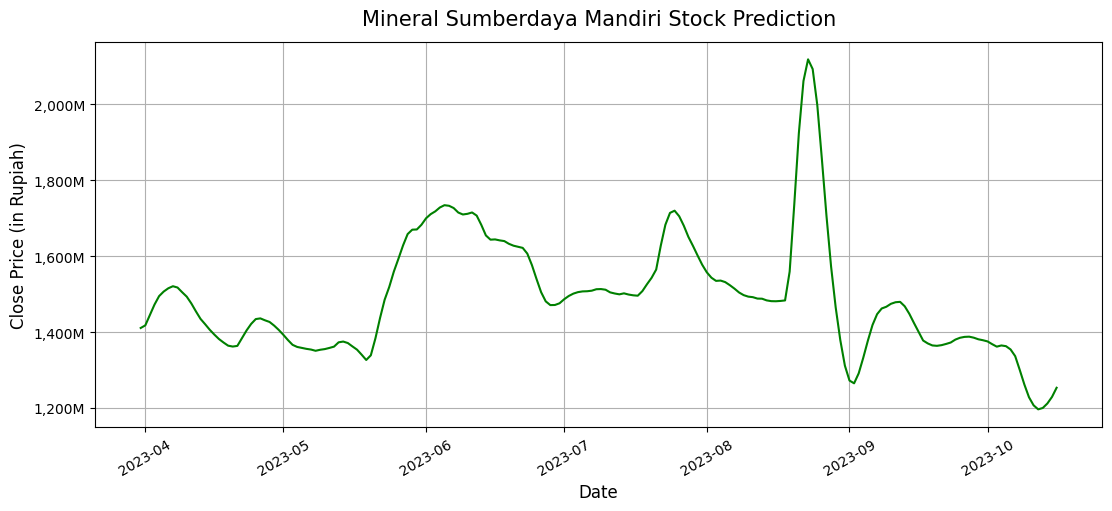

In [48]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [49]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 13s 300ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 2/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 3/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 4/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0022 - val_loss: 0.0064
Epoch 5/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 6/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 8/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0015 - val_loss: 0.003

In [50]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.0121695
Mean Absolute Percentage Error (MAPE): 0.07787
Root Mean Squared Error (RMSE): 0.01761
Mean Squared Error (MSE): 0.0003101
R-Squared (R2): 0.241825
T-Statistic 0.8787
P-Value 7.535168235900391e-13
Elapsed Time (min): 70.64


7/7 [==============================] - 0s 33ms/step


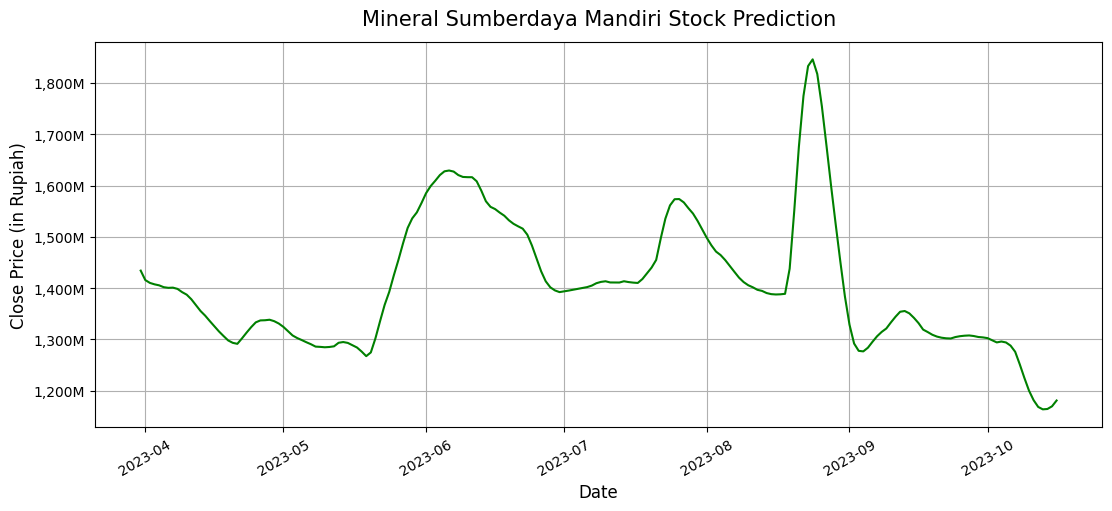

In [51]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [52]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 13s 297ms/step - loss: 0.0290 - val_loss: 0.1394
Epoch 2/10
24/24 [==============================] - 5s 211ms/step - loss: 0.0291 - val_loss: 0.1379
Epoch 3/10
24/24 [==============================] - 5s 211ms/step - loss: 0.0283 - val_loss: 0.1364
Epoch 4/10
24/24 [==============================] - 5s 214ms/step - loss: 0.0280 - val_loss: 0.1349
Epoch 5/10
24/24 [==============================] - 5s 216ms/step - loss: 0.0277 - val_loss: 0.1334
Epoch 6/10
24/24 [==============================] - 5s 217ms/step - loss: 0.0273 - val_loss: 0.1319
Epoch 7/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0268 - val_loss: 0.1304
Epoch 8/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0266 - val_loss: 0.1289
Epoch 9/10
24/24 [==============================] - 5s 218ms/step - loss: 0.0263 - val_loss: 0.1274
Epoch 10/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0259 - val_loss: 0.125

In [53]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 30ms/step
Mean Absolute Error (MAE): 0.1489624
Mean Absolute Percentage Error (MAPE): 0.99048
Root Mean Squared Error (RMSE): 0.15045
Mean Squared Error (MSE): 0.0226362
R-Squared (R2): -54.345658
T-Statistic 0.8488
P-Value 1.6513745869340367e-14
Elapsed Time (min): 61.74


7/7 [==============================] - 0s 32ms/step


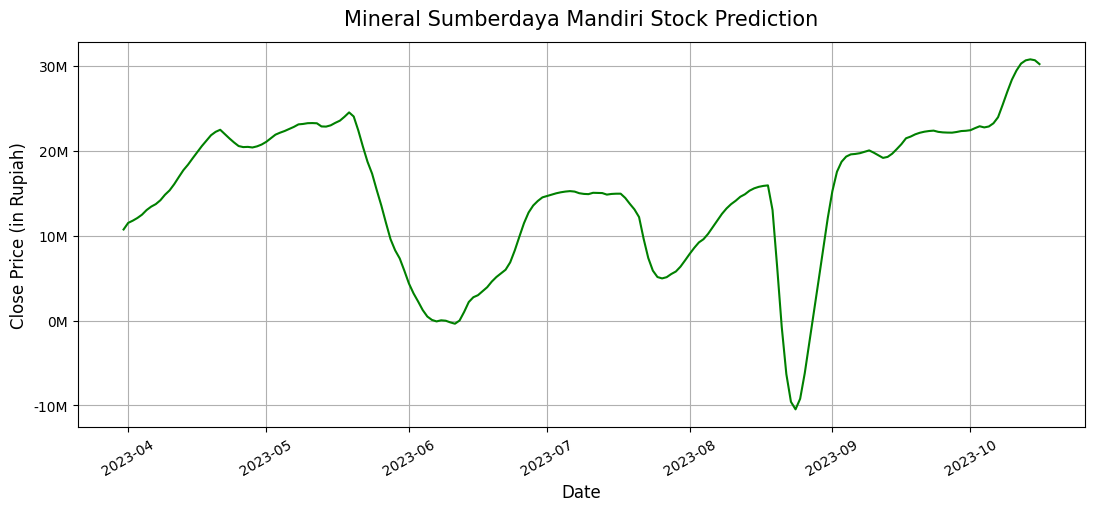

In [54]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [55]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 12s 253ms/step - loss: 0.0163 - val_loss: 0.0628
Epoch 2/10
24/24 [==============================] - 5s 196ms/step - loss: 0.0138 - val_loss: 0.0563
Epoch 3/10
24/24 [==============================] - 5s 194ms/step - loss: 0.0130 - val_loss: 0.0536
Epoch 4/10
24/24 [==============================] - 5s 190ms/step - loss: 0.0124 - val_loss: 0.0495
Epoch 5/10
24/24 [==============================] - 5s 198ms/step - loss: 0.0117 - val_loss: 0.0468
Epoch 6/10
24/24 [==============================] - 5s 195ms/step - loss: 0.0110 - val_loss: 0.0426
Epoch 7/10
24/24 [==============================] - 5s 193ms/step - loss: 0.0101 - val_loss: 0.0406
Epoch 8/10
24/24 [==============================] - 5s 221ms/step - loss: 0.0097 - val_loss: 0.0375
Epoch 9/10
24/24 [==============================] - 5s 201ms/step - loss: 0.0092 - val_loss: 0.0343
Epoch 10/10
24/24 [==============================] - 5s 201ms/step - loss: 0.0086 - val_loss: 0.032

In [56]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 31ms/step
Mean Absolute Error (MAE): 0.0321222
Mean Absolute Percentage Error (MAPE): 0.20511
Root Mean Squared Error (RMSE): 0.0361
Mean Squared Error (MSE): 0.0013033
R-Squared (R2): -2.186501
T-Statistic 0.6901
P-Value 1.1114109377981151e-20
Elapsed Time (min): 55.86


7/7 [==============================] - 0s 31ms/step


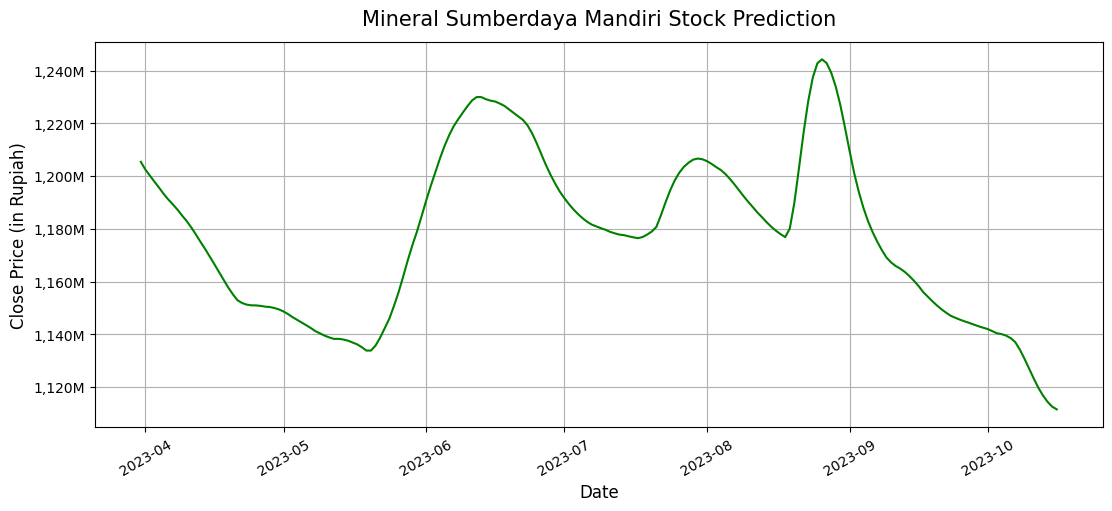

In [57]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [58]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 14s 319ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 2/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 3/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 5/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 6/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0011 - val_loss: 0.003

In [59]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.010161
Mean Absolute Percentage Error (MAPE): 0.06461
Root Mean Squared Error (RMSE): 0.01681
Mean Squared Error (MSE): 0.0002827
R-Squared (R2): 0.308798
T-Statistic 0.8733
P-Value 3.6199439713141546e-13
Elapsed Time (min): 72.75


7/7 [==============================] - 0s 36ms/step


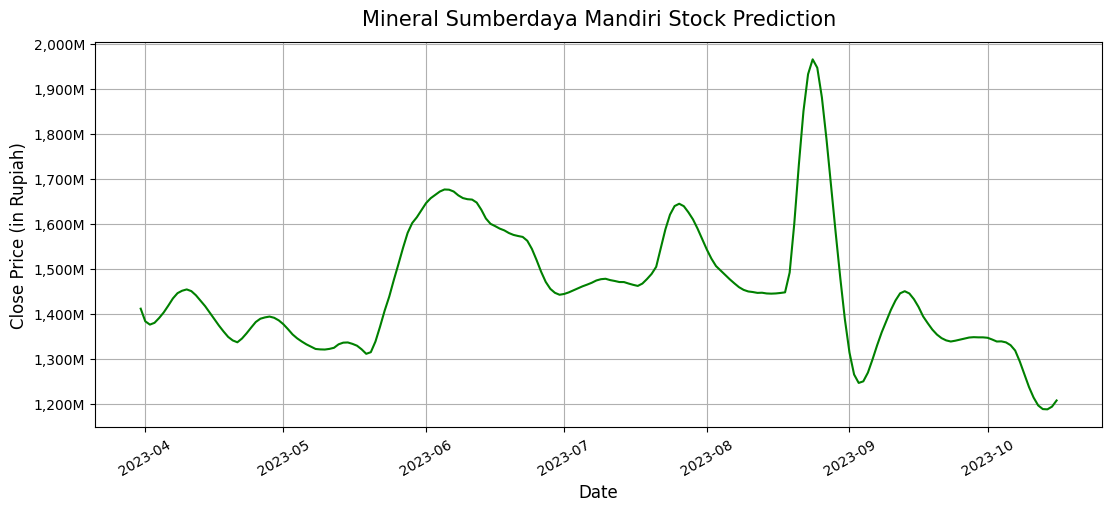

In [60]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [61]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 15s 340ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 2/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 3/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 4/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 5/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 7/10
24/24 [==============================] - 6s 247ms/step - loss: 9.7885e-04 - val_loss: 0.0030
Epoch 8/10
24/24 [==============================] - 6s 249ms/step - loss: 8.8725e-04 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 6s 261ms/step - loss: 8.6917e-04 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 6s 252ms/step - loss: 7.9192e-04 -

In [62]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.0092017
Mean Absolute Percentage Error (MAPE): 0.05953
Root Mean Squared Error (RMSE): 0.01467
Mean Squared Error (MSE): 0.0002152
R-Squared (R2): 0.473758
T-Statistic 0.8807
P-Value 1.0013167595426808e-12
Elapsed Time (min): 68.91


7/7 [==============================] - 0s 38ms/step


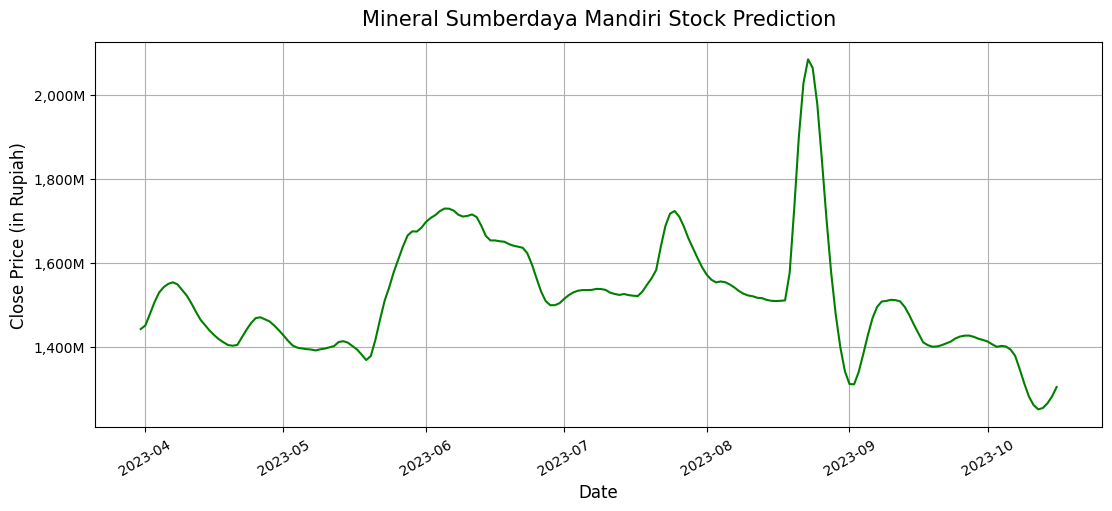

In [63]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [64]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 14s 348ms/step - loss: 0.0214 - val_loss: 0.0930
Epoch 2/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0170 - val_loss: 0.0789
Epoch 3/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0155 - val_loss: 0.0698
Epoch 4/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0142 - val_loss: 0.0642
Epoch 5/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0137 - val_loss: 0.0607
Epoch 6/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0134 - val_loss: 0.0581
Epoch 7/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0134 - val_loss: 0.0564
Epoch 8/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0132 - val_loss: 0.0550
Epoch 9/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0128 - val_loss: 0.0539
Epoch 10/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0128 - val_loss: 0.052

In [65]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.0485067
Mean Absolute Percentage Error (MAPE): 0.3124
Root Mean Squared Error (RMSE): 0.05217
Mean Squared Error (MSE): 0.0027219
R-Squared (R2): -5.655034
T-Statistic 0.6997
P-Value 2.2052617359205245e-20
Elapsed Time (min): 69.85


7/7 [==============================] - 0s 35ms/step


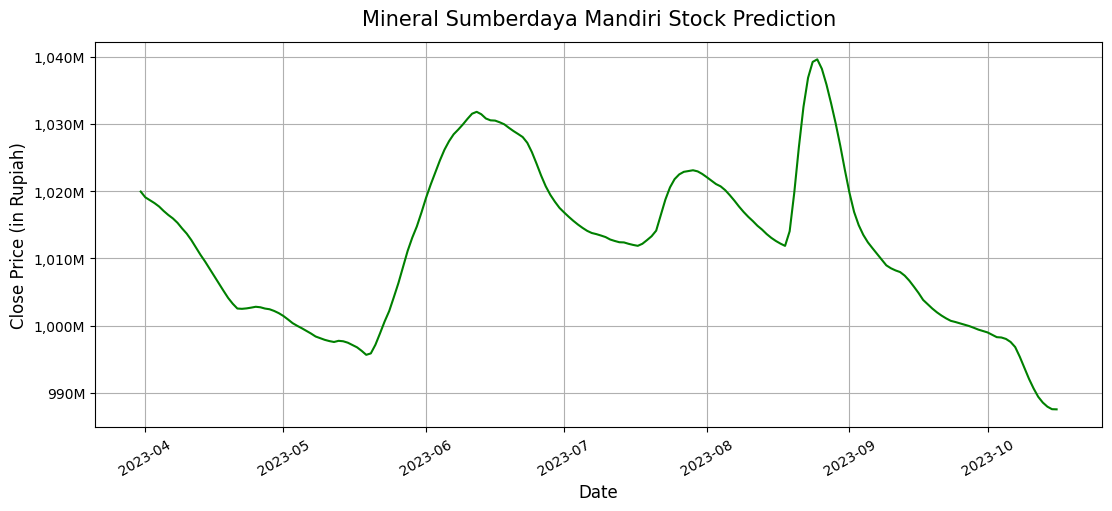

In [66]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [67]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 23s 641ms/step - loss: 0.0076 - val_loss: 0.0096
Epoch 2/10
24/24 [==============================] - 15s 621ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 14s 592ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 4/10
24/24 [==============================] - 16s 689ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 5/10
24/24 [==============================] - 15s 607ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 6/10
24/24 [==============================] - 15s 638ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 7/10
24/24 [==============================] - 15s 613ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 8/10
24/24 [==============================] - 15s 609ms/step - loss: 9.0314e-04 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 15s 634ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 15s 631ms/step - loss: 8.6441e-04 

In [68]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 59ms/step
Mean Absolute Error (MAE): 0.0087286
Mean Absolute Percentage Error (MAPE): 0.05504
Root Mean Squared Error (RMSE): 0.01493
Mean Squared Error (MSE): 0.0002229
R-Squared (R2): 0.455091
T-Statistic 0.8836
P-Value 1.5004128581935783e-12
Elapsed Time (min): 159.6


7/7 [==============================] - 0s 50ms/step


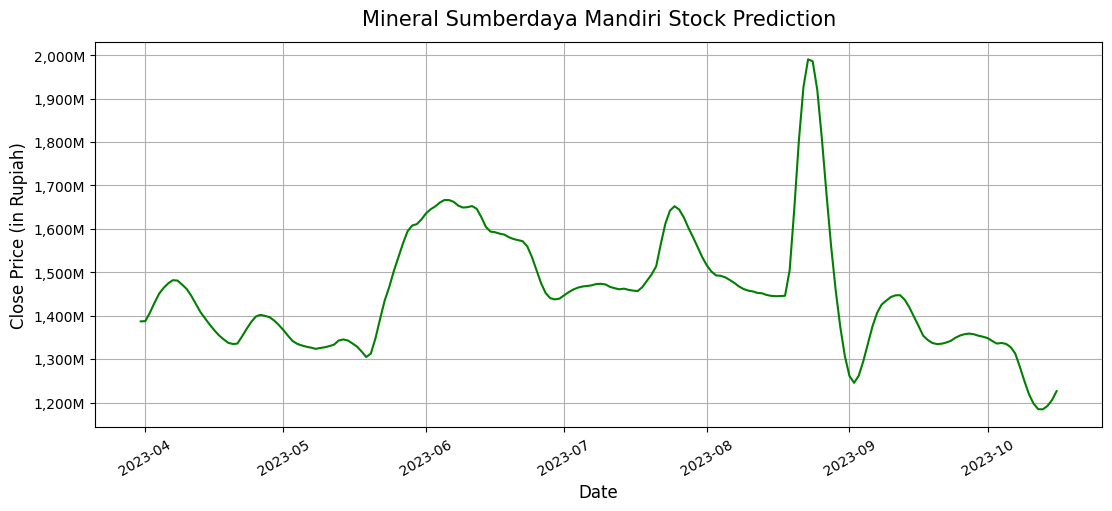

In [69]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [70]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 16s 355ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 2/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0031 - val_loss: 0.0053
Epoch 3/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0022 - val_loss: 0.0130
Epoch 4/10
24/24 [==============================] - 9s 377ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 5/10
24/24 [==============================] - 8s 349ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 6/10
24/24 [==============================] - 9s 362ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 8/10
24/24 [==============================] - 9s 364ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 9/10
24/24 [==============================] - 9s 368ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0013 - val_loss: 0.002

In [71]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.0114464
Mean Absolute Percentage Error (MAPE): 0.07319
Root Mean Squared Error (RMSE): 0.01848
Mean Squared Error (MSE): 0.0003416
R-Squared (R2): 0.164788
T-Statistic 0.8645
P-Value 1.1484982073445976e-13
Elapsed Time (min): 94.97


7/7 [==============================] - 0s 35ms/step


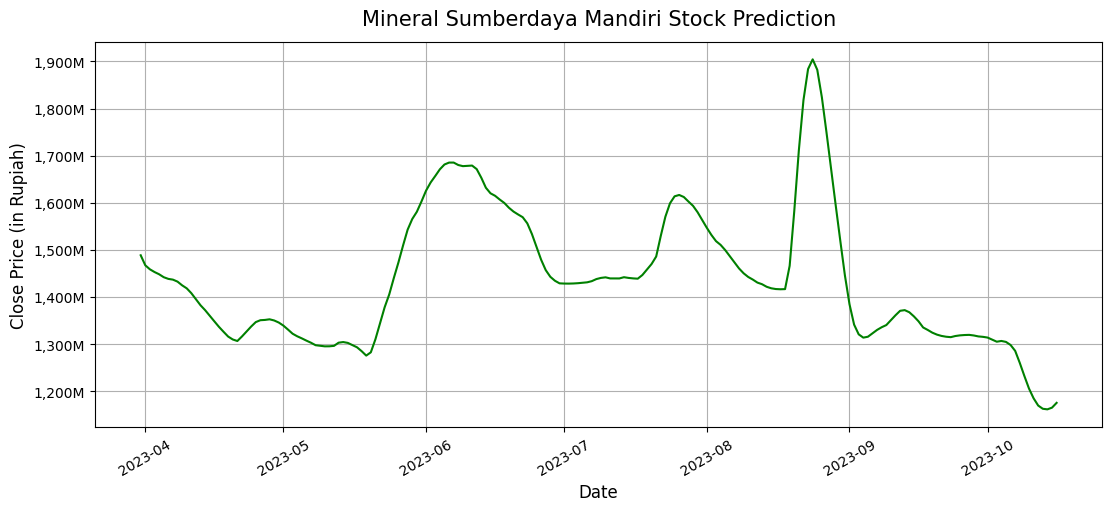

In [72]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [73]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 17s 419ms/step - loss: 0.0258 - val_loss: 0.1226
Epoch 2/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0256 - val_loss: 0.1216
Epoch 3/10
24/24 [==============================] - 12s 493ms/step - loss: 0.0253 - val_loss: 0.1206
Epoch 4/10
24/24 [==============================] - 12s 497ms/step - loss: 0.0256 - val_loss: 0.1197
Epoch 5/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0247 - val_loss: 0.1187
Epoch 6/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0246 - val_loss: 0.1177
Epoch 7/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0245 - val_loss: 0.1168
Epoch 8/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0241 - val_loss: 0.1158
Epoch 9/10
24/24 [==============================] - 14s 574ms/step - loss: 0.0240 - val_loss: 0.1149
Epoch 10/10
24/24 [==============================] - 13s 534ms/step - loss: 0.0238 - val_lo

In [74]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 63ms/step
Mean Absolute Error (MAE): 0.143245
Mean Absolute Percentage Error (MAPE): 0.95234
Root Mean Squared Error (RMSE): 0.14469
Mean Squared Error (MSE): 0.0209352
R-Squared (R2): -50.186554
T-Statistic 0.8346
P-Value 3.276040107458777e-15
Elapsed Time (min): 125.47


7/7 [==============================] - 0s 53ms/step


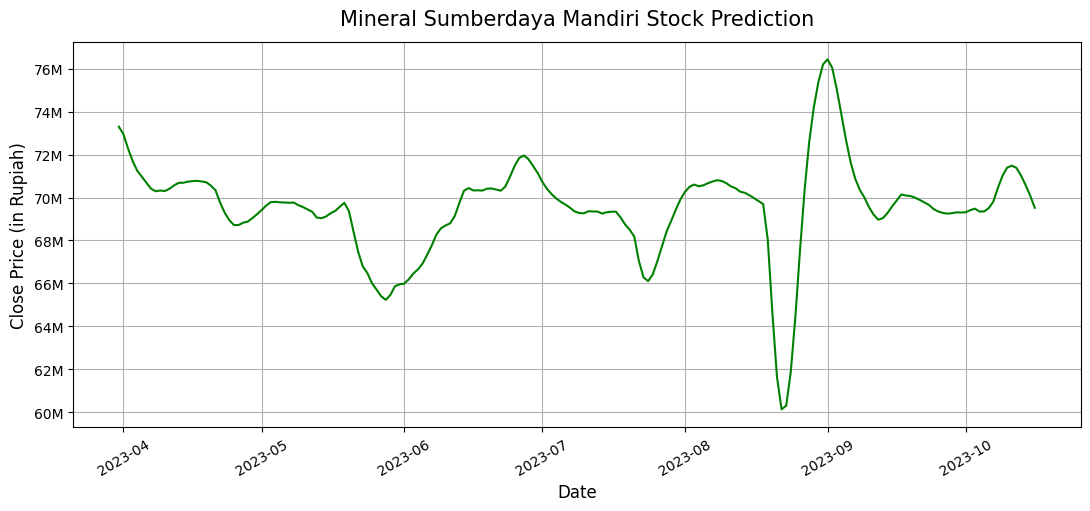

In [75]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [76]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 21s 566ms/step - loss: 0.0186 - val_loss: 0.0711
Epoch 2/10
24/24 [==============================] - 12s 478ms/step - loss: 0.0138 - val_loss: 0.0578
Epoch 3/10
24/24 [==============================] - 12s 516ms/step - loss: 0.0127 - val_loss: 0.0524
Epoch 4/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0122 - val_loss: 0.0494
Epoch 5/10
24/24 [==============================] - 13s 528ms/step - loss: 0.0118 - val_loss: 0.0479
Epoch 6/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0115 - val_loss: 0.0469
Epoch 7/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0113 - val_loss: 0.0452
Epoch 8/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0111 - val_loss: 0.0442
Epoch 9/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0109 - val_loss: 0.0442
Epoch 10/10
24/24 [==============================] - 10s 432ms/step - loss: 0.0109 - val_lo

In [77]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0420911
Mean Absolute Percentage Error (MAPE): 0.26995
Root Mean Squared Error (RMSE): 0.04589
Mean Squared Error (MSE): 0.0021055
R-Squared (R2): -4.147993
T-Statistic 0.7428
P-Value 5.816702531212037e-19
Elapsed Time (min): 124.06


7/7 [==============================] - 0s 41ms/step


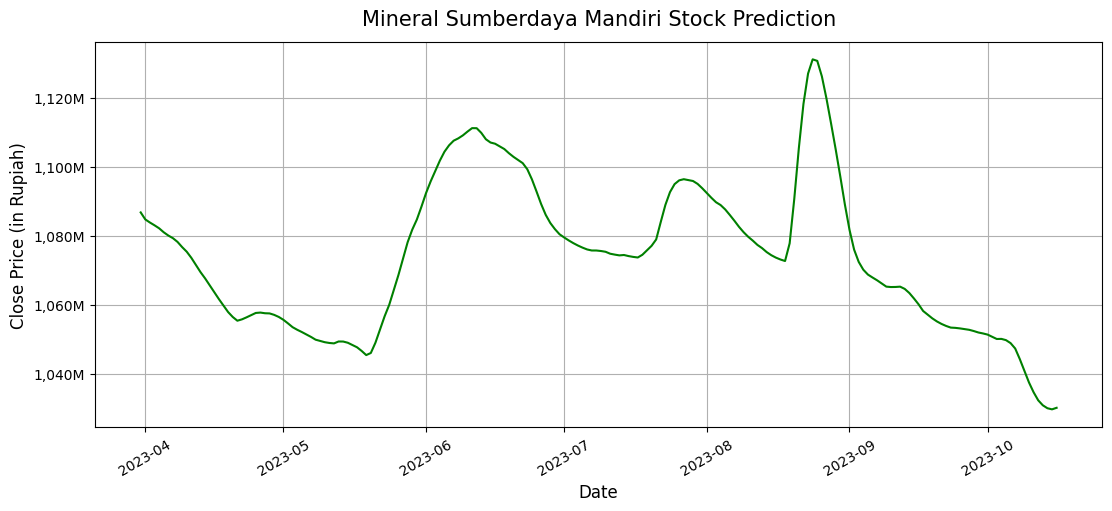

In [78]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [79]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 19s 524ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 2/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 3/10
24/24 [==============================] - 12s 493ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4/10
24/24 [==============================] - 11s 467ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 5/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 6/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 8/10
24/24 [==============================] - 11s 467ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 9/10
24/24 [==============================] - 12s 488ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 10/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0012 - val_lo

In [80]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.0113915
Mean Absolute Percentage Error (MAPE): 0.07413
Root Mean Squared Error (RMSE): 0.01868
Mean Squared Error (MSE): 0.0003488
R-Squared (R2): 0.147181
T-Statistic 0.8691
P-Value 2.0709417525039547e-13
Elapsed Time (min): 121.97


7/7 [==============================] - 0s 42ms/step


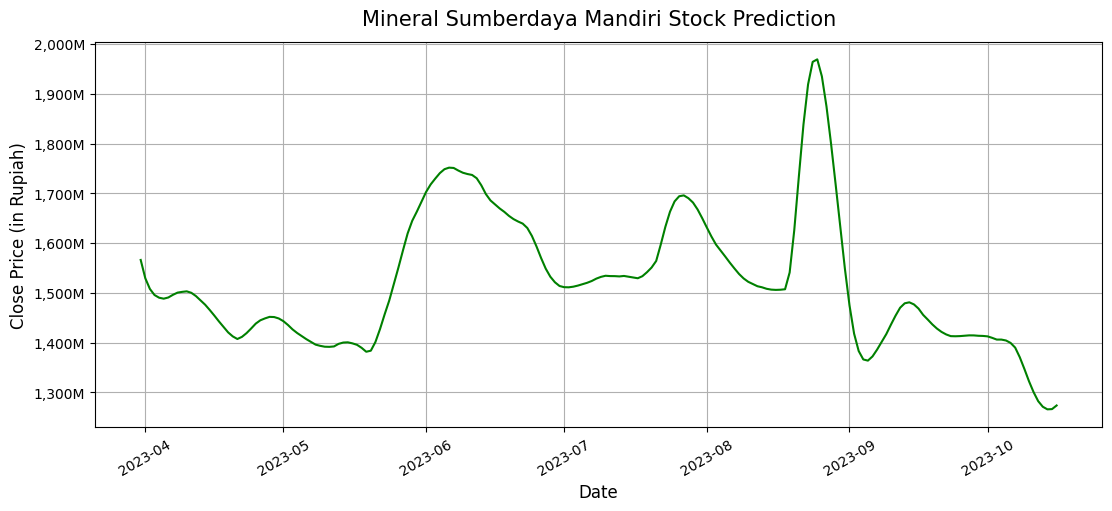

In [81]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [82]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 19s 531ms/step - loss: 0.2765 - val_loss: 0.0775
Epoch 2/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0168 - val_loss: 0.0497
Epoch 3/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0126 - val_loss: 0.0240
Epoch 4/10
24/24 [==============================] - 12s 480ms/step - loss: 0.0084 - val_loss: 0.0067
Epoch 5/10
24/24 [==============================] - 12s 498ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 6/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 7/10
24/24 [==============================] - 11s 480ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 8/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 9/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0040 - val_lo

In [83]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.019353
Mean Absolute Percentage Error (MAPE): 0.13194
Root Mean Squared Error (RMSE): 0.02513
Mean Squared Error (MSE): 0.0006315
R-Squared (R2): -0.544032
T-Statistic 0.8045
P-Value 1.4057665842075748e-16
Elapsed Time (min): 123.66


7/7 [==============================] - 0s 41ms/step


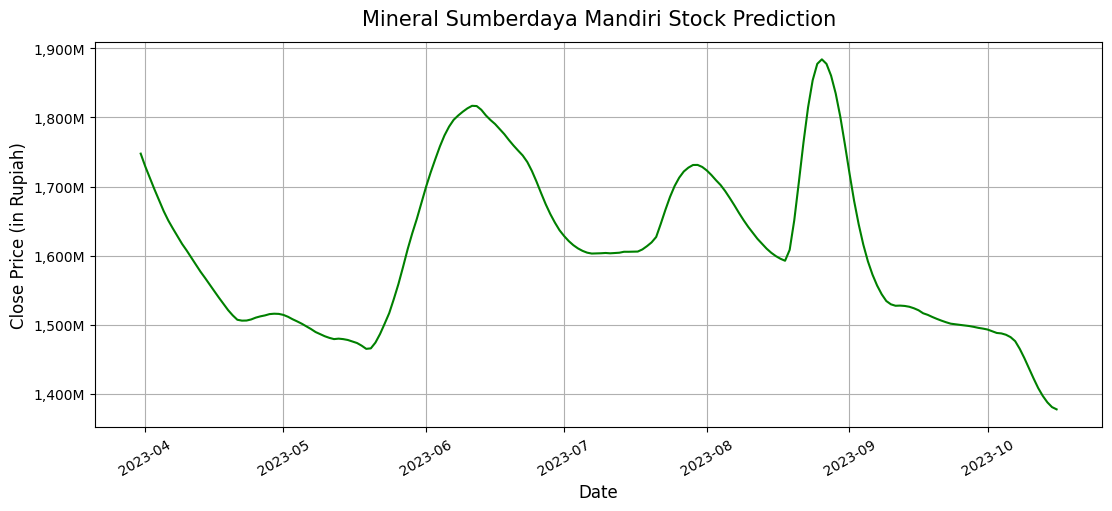

In [84]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [85]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 20s 614ms/step - loss: 0.2536 - val_loss: 0.4356
Epoch 2/10
24/24 [==============================] - 12s 517ms/step - loss: 0.1651 - val_loss: 0.3458
Epoch 3/10
24/24 [==============================] - 12s 522ms/step - loss: 0.1208 - val_loss: 0.2872
Epoch 4/10
24/24 [==============================] - 13s 532ms/step - loss: 0.0924 - val_loss: 0.2448
Epoch 5/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0727 - val_loss: 0.2125
Epoch 6/10
24/24 [==============================] - 13s 539ms/step - loss: 0.0584 - val_loss: 0.1871
Epoch 7/10
24/24 [==============================] - 14s 586ms/step - loss: 0.0478 - val_loss: 0.1667
Epoch 8/10
24/24 [==============================] - 15s 640ms/step - loss: 0.0400 - val_loss: 0.1500
Epoch 9/10
24/24 [==============================] - 14s 584ms/step - loss: 0.0340 - val_loss: 0.1363
Epoch 10/10
24/24 [==============================] - 13s 558ms/step - loss: 0.0294 - val_lo

In [86]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.1630507
Mean Absolute Percentage Error (MAPE): 1.08658
Root Mean Squared Error (RMSE): 0.16428
Mean Squared Error (MSE): 0.0269892
R-Squared (R2): -64.988846
T-Statistic 0.649
P-Value 7.144771531184818e-22
Elapsed Time (min): 141.03


7/7 [==============================] - 0s 47ms/step


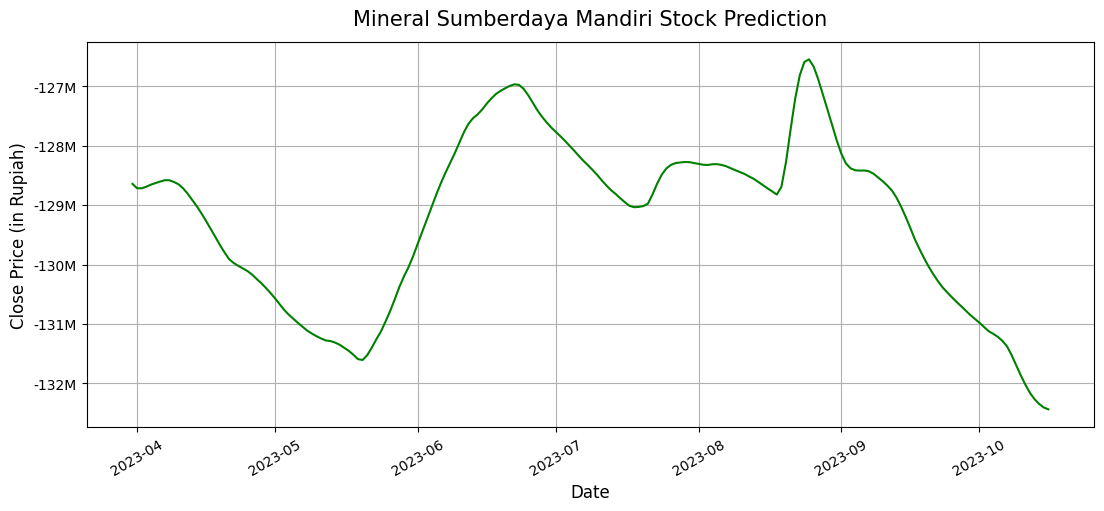

In [87]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [88]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 24s 632ms/step - loss: 0.5759 - val_loss: 0.0431
Epoch 2/10
24/24 [==============================] - 14s 571ms/step - loss: 0.0236 - val_loss: 0.0564
Epoch 3/10
24/24 [==============================] - 13s 552ms/step - loss: 0.0215 - val_loss: 0.0631
Epoch 4/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0199 - val_loss: 0.0474
Epoch 5/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0181 - val_loss: 0.0479
Epoch 6/10
24/24 [==============================] - 13s 531ms/step - loss: 0.0177 - val_loss: 0.0425
Epoch 7/10
24/24 [==============================] - 14s 603ms/step - loss: 0.0173 - val_loss: 0.0568
Epoch 8/10
24/24 [==============================] - 13s 546ms/step - loss: 0.0163 - val_loss: 0.0424
Epoch 9/10
24/24 [==============================] - 13s 557ms/step - loss: 0.0165 - val_loss: 0.0605
Epoch 10/10
24/24 [==============================] - 14s 597ms/step - loss: 0.0161 - val_lo

In [89]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 44ms/step
Mean Absolute Error (MAE): 0.0243529
Mean Absolute Percentage Error (MAPE): 0.15161
Root Mean Squared Error (RMSE): 0.03039
Mean Squared Error (MSE): 0.0009234
R-Squared (R2): -1.257778
T-Statistic 0.7961
P-Value 6.209389425062422e-17
Elapsed Time (min): 145.99


7/7 [==============================] - 0s 46ms/step


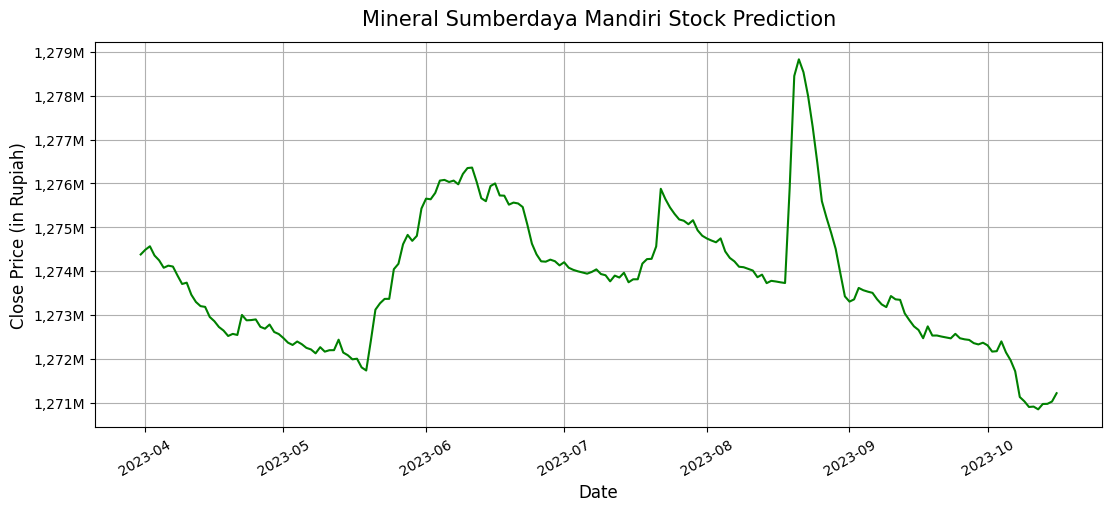

In [90]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [91]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 22s 623ms/step - loss: 0.4540 - val_loss: 0.0504
Epoch 2/10
24/24 [==============================] - 12s 515ms/step - loss: 0.0287 - val_loss: 0.0411
Epoch 3/10
24/24 [==============================] - 13s 524ms/step - loss: 0.0252 - val_loss: 0.0412
Epoch 4/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0262 - val_loss: 0.0552
Epoch 5/10
24/24 [==============================] - 13s 532ms/step - loss: 0.0230 - val_loss: 0.0360
Epoch 6/10
24/24 [==============================] - 13s 542ms/step - loss: 0.0225 - val_loss: 0.0301
Epoch 7/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0157 - val_loss: 0.0227
Epoch 8/10
24/24 [==============================] - 13s 542ms/step - loss: 0.0139 - val_loss: 0.0110
Epoch 9/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 10/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0102 - val_lo

In [92]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 48ms/step
Mean Absolute Error (MAE): 0.0561583
Mean Absolute Percentage Error (MAPE): 0.37023
Root Mean Squared Error (RMSE): 0.05925
Mean Squared Error (MSE): 0.0035103
R-Squared (R2): -7.582663
T-Statistic 0.6907
P-Value 1.1577835391990188e-20
Elapsed Time (min): 139.68


7/7 [==============================] - 0s 48ms/step


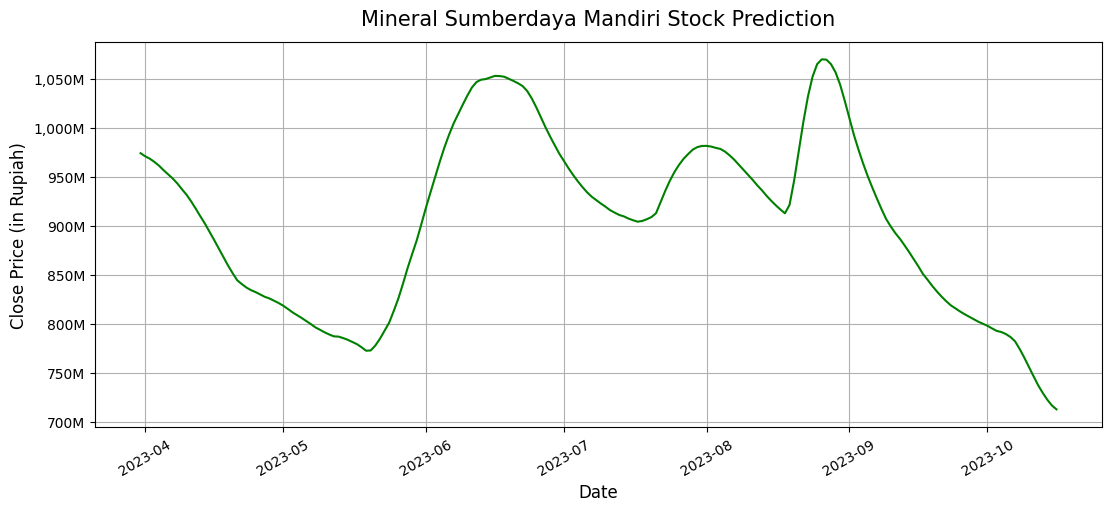

In [93]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [94]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 20s 468ms/step - loss: 0.0263 - val_loss: 0.1219
Epoch 2/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0262 - val_loss: 0.1213
Epoch 3/10
24/24 [==============================] - 9s 364ms/step - loss: 0.0259 - val_loss: 0.1206
Epoch 4/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0257 - val_loss: 0.1200
Epoch 5/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0255 - val_loss: 0.1193
Epoch 6/10
24/24 [==============================] - 8s 339ms/step - loss: 0.0253 - val_loss: 0.1186
Epoch 7/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0251 - val_loss: 0.1180
Epoch 8/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0249 - val_loss: 0.1173
Epoch 9/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0247 - val_loss: 0.1166
Epoch 10/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0245 - val_loss: 0.115

In [95]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.1499146
Mean Absolute Percentage Error (MAPE): 0.99783
Root Mean Squared Error (RMSE): 0.15124
Mean Squared Error (MSE): 0.0228744
R-Squared (R2): -54.92794
T-Statistic 0.8777
P-Value 6.526584286035975e-13
Elapsed Time (min): 96.16


7/7 [==============================] - 0s 40ms/step


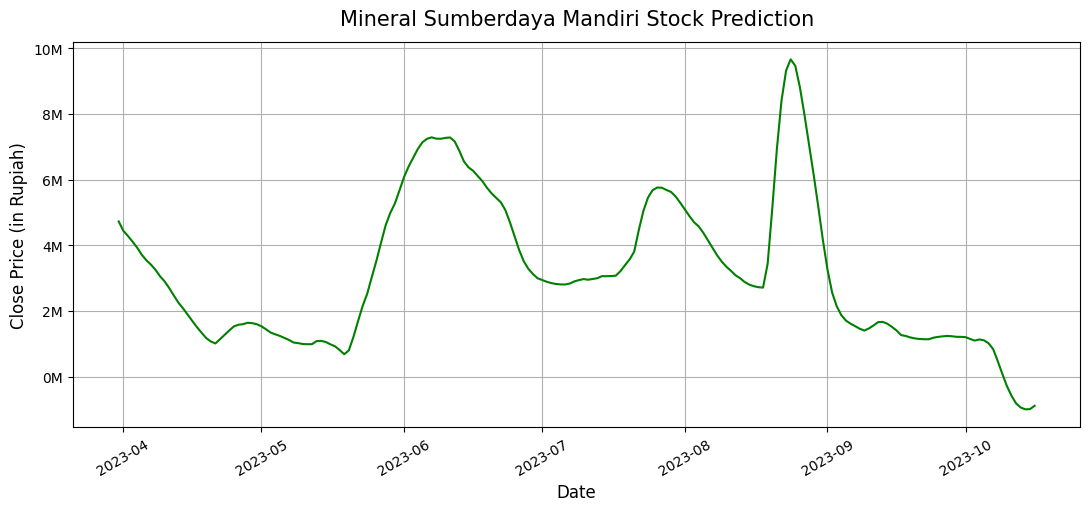

In [96]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [97]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 21s 623ms/step - loss: 0.0716 - val_loss: 0.0623
Epoch 2/10
24/24 [==============================] - 13s 537ms/step - loss: 0.0147 - val_loss: 0.0627
Epoch 3/10
24/24 [==============================] - 14s 570ms/step - loss: 0.0146 - val_loss: 0.0624
Epoch 4/10
24/24 [==============================] - 13s 545ms/step - loss: 0.0146 - val_loss: 0.0606
Epoch 5/10
24/24 [==============================] - 13s 549ms/step - loss: 0.0145 - val_loss: 0.0601
Epoch 6/10
24/24 [==============================] - 13s 563ms/step - loss: 0.0145 - val_loss: 0.0618
Epoch 7/10
24/24 [==============================] - 13s 538ms/step - loss: 0.0145 - val_loss: 0.0616
Epoch 8/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0144 - val_loss: 0.0607
Epoch 9/10
24/24 [==============================] - 13s 553ms/step - loss: 0.0143 - val_loss: 0.0618
Epoch 10/10
24/24 [==============================] - 13s 550ms/step - loss: 0.0144 - val_lo

In [98]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 58ms/step
Mean Absolute Error (MAE): 0.0494638
Mean Absolute Percentage Error (MAPE): 0.31817
Root Mean Squared Error (RMSE): 0.05338
Mean Squared Error (MSE): 0.0028497
R-Squared (R2): -5.967611
T-Statistic 0.7412
P-Value 5.102374686617502e-19
Elapsed Time (min): 141.85


7/7 [==============================] - 0s 53ms/step


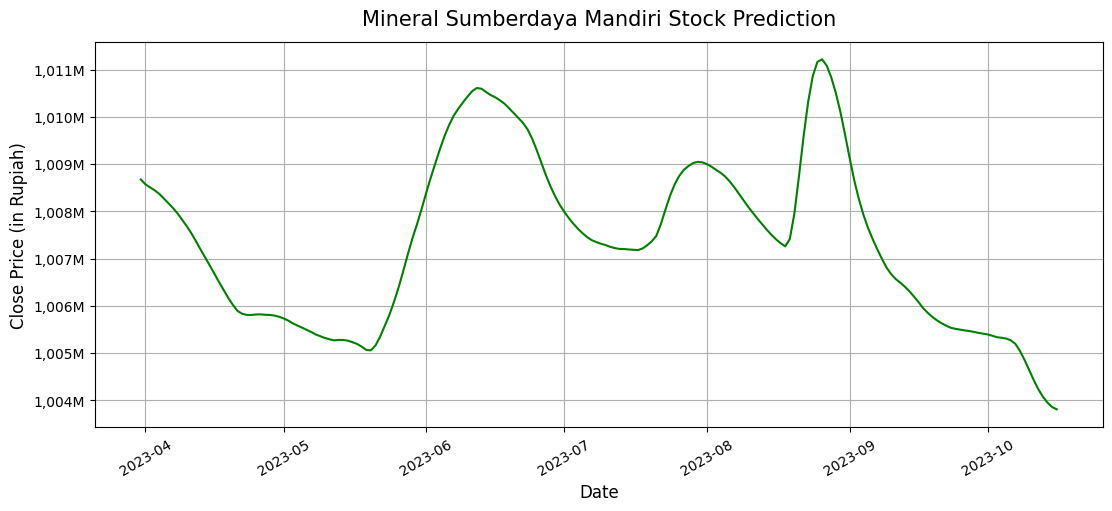

In [99]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [100]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 21s 600ms/step - loss: 0.2611 - val_loss: 0.0895
Epoch 2/10
24/24 [==============================] - 14s 575ms/step - loss: 0.0311 - val_loss: 0.0752
Epoch 3/10
24/24 [==============================] - 13s 556ms/step - loss: 0.0213 - val_loss: 0.0600
Epoch 4/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0164 - val_loss: 0.0255
Epoch 5/10
24/24 [==============================] - 14s 578ms/step - loss: 0.0108 - val_loss: 0.0082
Epoch 6/10
24/24 [==============================] - 14s 577ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 7/10
24/24 [==============================] - 14s 585ms/step - loss: 0.0087 - val_loss: 0.0066
Epoch 8/10
24/24 [==============================] - 13s 556ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 9/10
24/24 [==============================] - 14s 572ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 10/10
24/24 [==============================] - 14s 584ms/step - loss: 0.0071 - val_lo

In [101]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 51ms/step
Mean Absolute Error (MAE): 0.0172551
Mean Absolute Percentage Error (MAPE): 0.11511
Root Mean Squared Error (RMSE): 0.02841
Mean Squared Error (MSE): 0.0008072
R-Squared (R2): -0.973561
T-Statistic 0.6194
P-Value 1.14482359708481e-22
Elapsed Time (min): 146.15


7/7 [==============================] - 0s 50ms/step


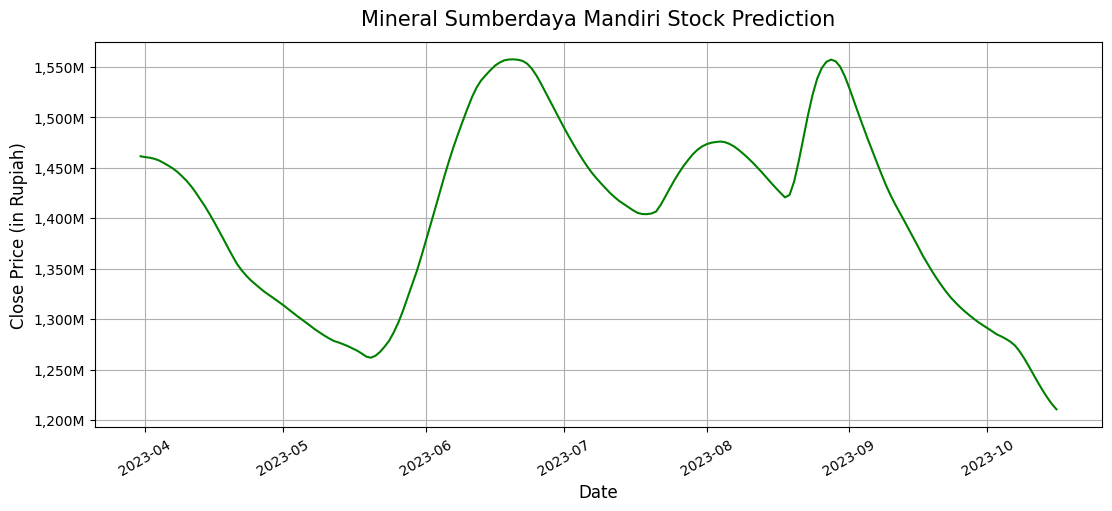

In [102]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [103]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 23s 634ms/step - loss: 0.0048 - val_loss: 0.0077
Epoch 2/10
24/24 [==============================] - 13s 563ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 3/10
24/24 [==============================] - 14s 587ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 14s 564ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 14s 605ms/step - loss: 8.5566e-04 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 14s 572ms/step - loss: 8.9602e-04 - val_loss: 0.0035
Epoch 7/10
24/24 [==============================] - 14s 574ms/step - loss: 9.1881e-04 - val_loss: 0.0024
Epoch 8/10
24/24 [==============================] - 15s 648ms/step - loss: 8.0551e-04 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 15s 640ms/step - loss: 8.2556e-04 - val_loss: 0.0023
Epoch 10/10
24/24 [==============================] - 15s 624ms/step - l

In [104]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Error (MAE): 0.0090437
Mean Absolute Percentage Error (MAPE): 0.05816
Root Mean Squared Error (RMSE): 0.0144
Mean Squared Error (MSE): 0.0002074
R-Squared (R2): 0.492926
T-Statistic 0.8812
P-Value 1.0742120084075713e-12
Elapsed Time (min): 152.41


7/7 [==============================] - 0s 54ms/step


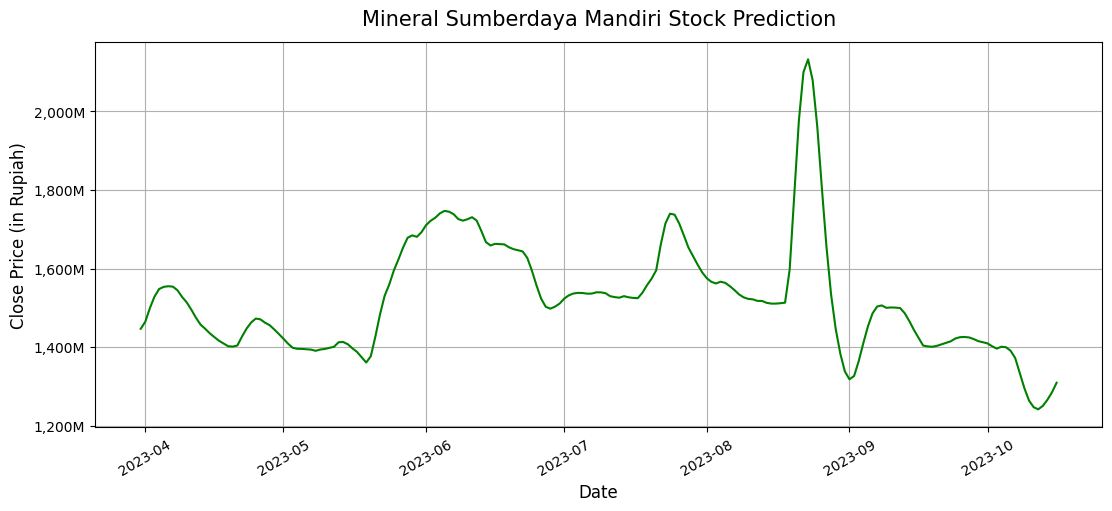

In [105]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [106]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 23s 685ms/step - loss: 0.0122 - val_loss: 0.0485
Epoch 2/10
24/24 [==============================] - 14s 582ms/step - loss: 0.0096 - val_loss: 0.0415
Epoch 3/10
24/24 [==============================] - 15s 614ms/step - loss: 0.0092 - val_loss: 0.0385
Epoch 4/10
24/24 [==============================] - 14s 570ms/step - loss: 0.0092 - val_loss: 0.0373
Epoch 5/10
24/24 [==============================] - 14s 571ms/step - loss: 0.0091 - val_loss: 0.0363
Epoch 6/10
24/24 [==============================] - 14s 563ms/step - loss: 0.0086 - val_loss: 0.0357
Epoch 7/10
24/24 [==============================] - 13s 527ms/step - loss: 0.0088 - val_loss: 0.0350
Epoch 8/10
24/24 [==============================] - 13s 546ms/step - loss: 0.0085 - val_loss: 0.0344
Epoch 9/10
24/24 [==============================] - 13s 558ms/step - loss: 0.0083 - val_loss: 0.0339
Epoch 10/10
24/24 [==============================] - 13s 561ms/step - loss: 0.0081 - val_lo

In [107]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Error (MAE): 0.0344255
Mean Absolute Percentage Error (MAPE): 0.21993
Root Mean Squared Error (RMSE): 0.03832
Mean Squared Error (MSE): 0.0014682
R-Squared (R2): -2.5897
T-Statistic 0.7332
P-Value 2.7168343968755574e-19
Elapsed Time (min): 145.63


7/7 [==============================] - 0s 50ms/step


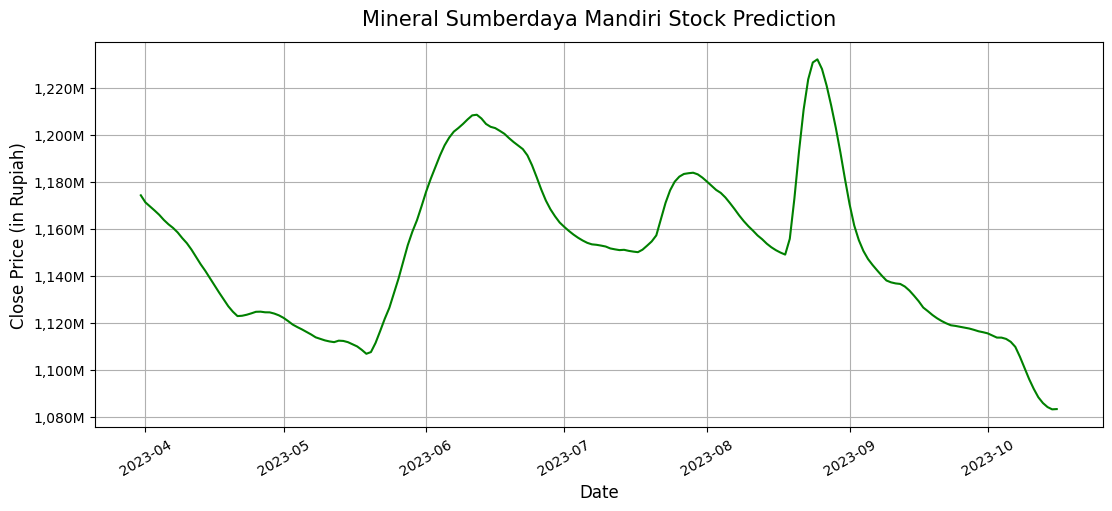

In [108]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [109]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 23s 559ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 2/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 3/10
24/24 [==============================] - 11s 477ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 4/10
24/24 [==============================] - 13s 525ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 5/10
24/24 [==============================] - 12s 520ms/step - loss: 9.9446e-04 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 11s 472ms/step - loss: 9.3843e-04 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 12s 492ms/step - loss: 9.1919e-04 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 12s 505ms/step - loss: 9.2548e-04 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 13s 525ms/step - loss: 9.2951e-04 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 12s 510ms/step - l

In [110]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.0102366
Mean Absolute Percentage Error (MAPE): 0.06524
Root Mean Squared Error (RMSE): 0.01538
Mean Squared Error (MSE): 0.0002365
R-Squared (R2): 0.421734
T-Statistic 0.8892
P-Value 3.3359584625941574e-12
Elapsed Time (min): 131.69


7/7 [==============================] - 0s 48ms/step


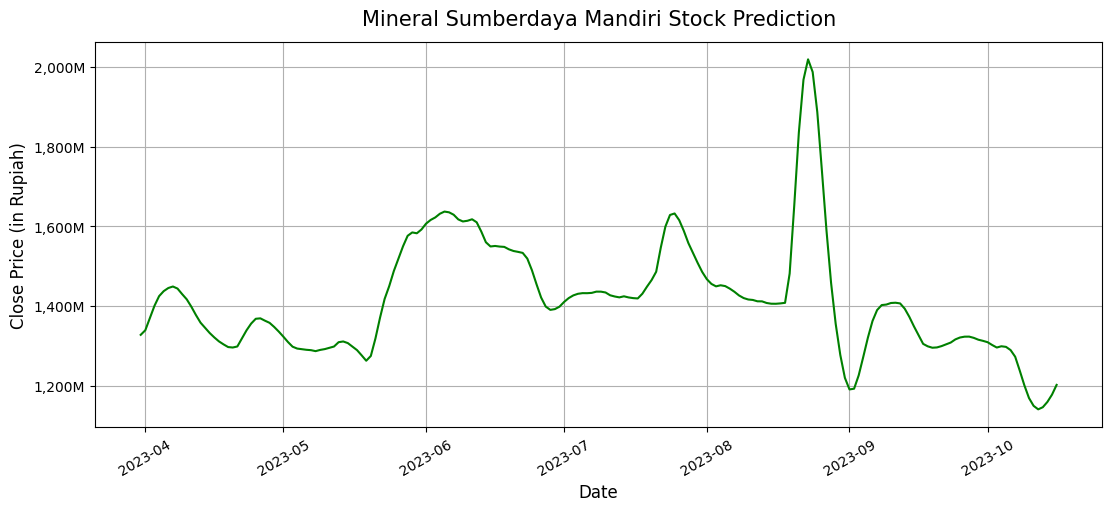

In [111]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [112]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 20s 534ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 2/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 3/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 4/10
24/24 [==============================] - 11s 472ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 5/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 6/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0012 - val_lo

In [113]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Error (MAE): 0.0306817
Mean Absolute Percentage Error (MAPE): 0.20674
Root Mean Squared Error (RMSE): 0.03335
Mean Squared Error (MSE): 0.0011123
R-Squared (R2): -1.719613
T-Statistic 0.8745
P-Value 4.251432105667474e-13
Elapsed Time (min): 119.19


7/7 [==============================] - 0s 45ms/step


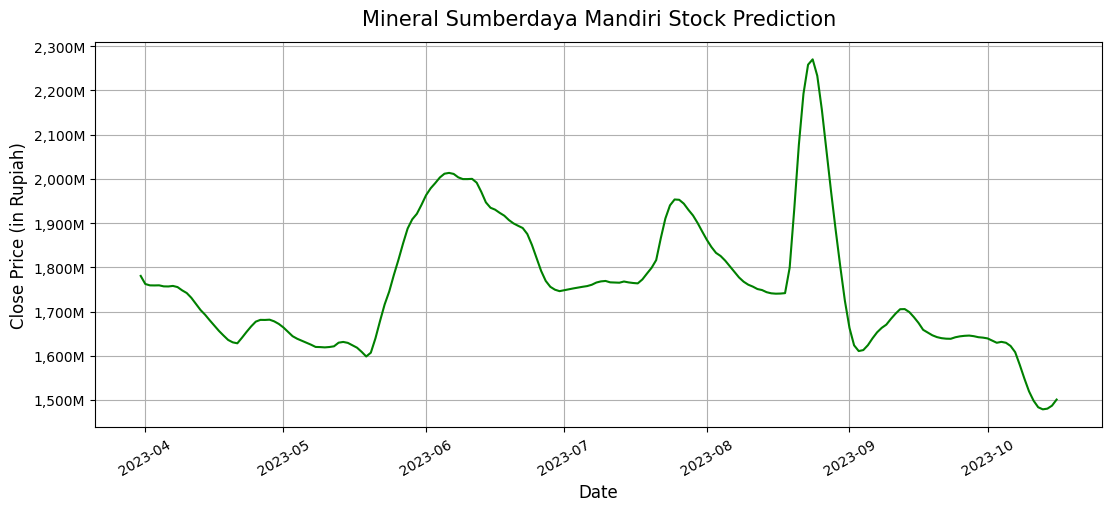

In [114]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [115]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 17s 460ms/step - loss: 0.0219 - val_loss: 0.1039
Epoch 2/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0216 - val_loss: 0.1024
Epoch 3/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0213 - val_loss: 0.1010
Epoch 4/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0209 - val_loss: 0.0995
Epoch 5/10
24/24 [==============================] - 9s 388ms/step - loss: 0.0205 - val_loss: 0.0980
Epoch 6/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0202 - val_loss: 0.0966
Epoch 7/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0199 - val_loss: 0.0951
Epoch 8/10
24/24 [==============================] - 9s 393ms/step - loss: 0.0195 - val_loss: 0.0937
Epoch 9/10
24/24 [==============================] - 9s 383ms/step - loss: 0.0191 - val_loss: 0.0923
Epoch 10/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0189 - val_loss: 0.

In [116]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.1230653
Mean Absolute Percentage Error (MAPE): 0.81659
Root Mean Squared Error (RMSE): 0.12459
Mean Squared Error (MSE): 0.0155235
R-Squared (R2): -36.955095
T-Statistic 0.6873
P-Value 9.165859928522955e-21
Elapsed Time (min): 102.71


7/7 [==============================] - 0s 43ms/step


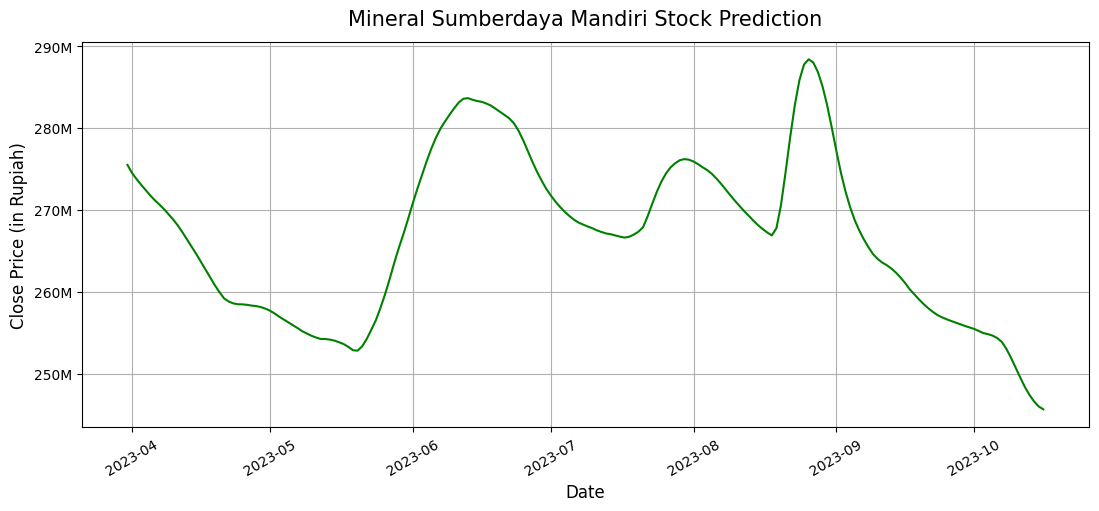

In [117]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [118]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 14s 342ms/step - loss: 0.0195 - val_loss: 0.0745
Epoch 2/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0162 - val_loss: 0.0645
Epoch 3/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0152 - val_loss: 0.0587
Epoch 4/10
24/24 [==============================] - 7s 307ms/step - loss: 0.0137 - val_loss: 0.0541
Epoch 5/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0127 - val_loss: 0.0506
Epoch 6/10
24/24 [==============================] - 7s 312ms/step - loss: 0.0116 - val_loss: 0.0454
Epoch 7/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0109 - val_loss: 0.0434
Epoch 8/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0101 - val_loss: 0.0393
Epoch 9/10
24/24 [==============================] - 8s 332ms/step - loss: 0.0091 - val_loss: 0.0347
Epoch 10/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0085 - val_loss: 0.033

In [119]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.0364033
Mean Absolute Percentage Error (MAPE): 0.23353
Root Mean Squared Error (RMSE): 0.04012
Mean Squared Error (MSE): 0.0016099
R-Squared (R2): -2.936262
T-Statistic 0.6713
P-Value 3.0771328813300036e-21
Elapsed Time (min): 82.7


7/7 [==============================] - 0s 43ms/step


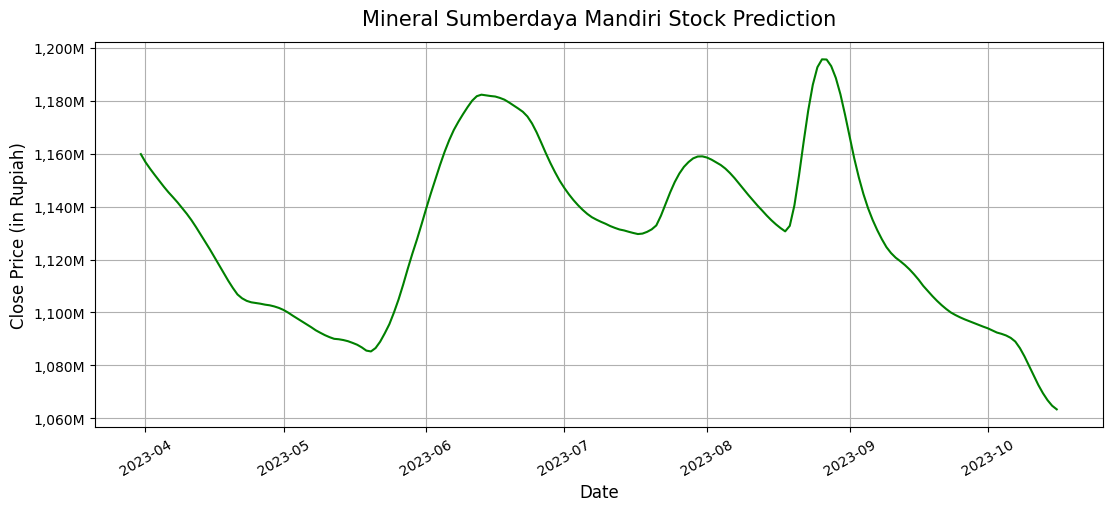

In [120]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [121]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 18s 451ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 2/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 3/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 7/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 8/10
24/24 [==============================] - 10s 401ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 9/10
24/24 [==============================] - 9s 377ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 9s 383ms/step - loss: 0.0011 - val_loss: 0

In [122]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 54ms/step
Mean Absolute Error (MAE): 0.0107538
Mean Absolute Percentage Error (MAPE): 0.06853
Root Mean Squared Error (RMSE): 0.01826
Mean Squared Error (MSE): 0.0003335
R-Squared (R2): 0.184673
T-Statistic 0.8739
P-Value 3.9463359880267945e-13
Elapsed Time (min): 103.84


7/7 [==============================] - 0s 55ms/step


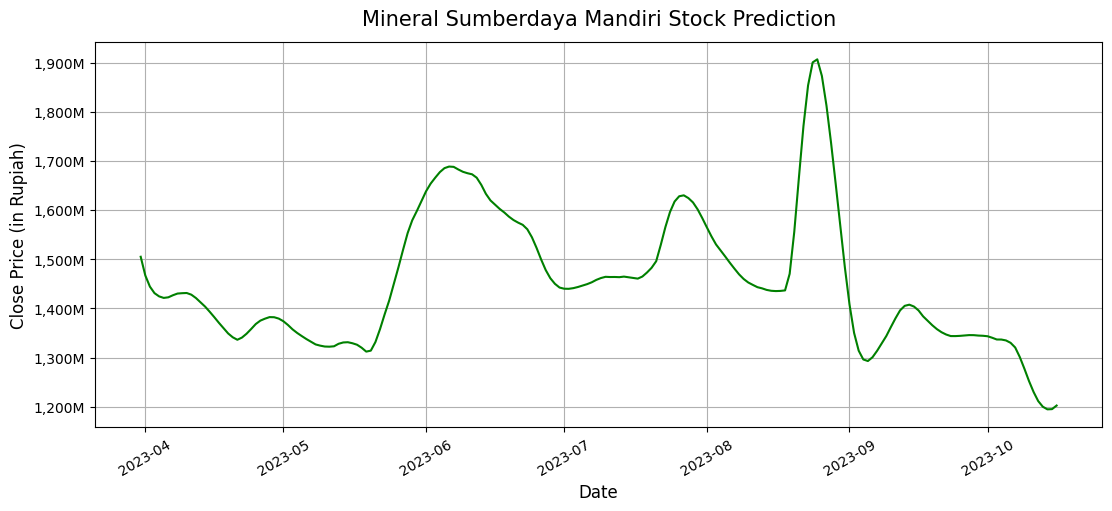

In [123]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [124]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
import time
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 50ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 41ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 42ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 52ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 47ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 44ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 47ms/step
Training

In [125]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta               110.78  0.11828   0.78426  0.01436   
           adagrad                 98.53  0.04625   0.29671  0.00252   
           adam                   106.17  0.01041   0.06656  0.00023   
           adamax                 120.72  0.01135   0.07348  0.00038   
           nadam                  113.26  0.00798   0.05065  0.00019   
           rmsprop                114.27  0.01051   0.06687  0.00029   
           sgd                    119.57  0.03113   0.19884  0.00123   
relu       adadelta               113.06  0.16932   1.12774  0.02916   
           adagrad                138.16  0.04291   0.27572  0.00217   
           adam                   126.56  0.00881   0.05585  0.00023   
           adamax                 129.67  0.01211   0.07884  0.00039   
           nadam                  156.51  0.00896   0.05689  0.00023   
           rmsprop                115.49  0.01354   0.08710  0.00034   
           sgd                    126.23  0.03560   0.22805  0.00155   
sigmoid    adadelta               107.70  0.10973   0.72570  0.01245   
           adagrad                105.86  0.04494   0.28753  0.00242   
           adam                   101.65  0.01086   0.06949  0.00035   
           adamax                 108.55  0.01162   0.07487  0.00040   
           nadam                  109.20  0.02094   0.14043  0.00065   
           rmsprop                115.42  0.04361   0.28667  0.00218   
           sgd                    103.37  0.04937   0.31788  0.00283   
tanh       adadelta                99.87  0.12849   0.85312  0.01689   
           adagrad                121.43  0.04596   0.29502  0.00249   
           adam                   119.28  0.01235   0.08052  0.00029   
           adamax                 111.03  0.00958   0.06117  0.00028   
           nadam                  123.92  0.01305   0.08483  0.00032   
           rmsprop                121.65  0.01029   0.06695  0.00028   
           sgd                    101.17  0.03940   0.25213  0.00188   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   8.821398e-22         -34.12   0.11983     0.652283  
           adagrad    7.529668e-21          -5.17   0.05020     0.684475  
           adam       5.273120e-12           0.44   0.01517     0.892252  
           adamax     1.212501e-14           0.06   0.01949     0.846131  
           nadam      9.058834e-13           0.53   0.01378     0.880028  
           rmsprop    1.707508e-13           0.30   0.01703     0.867606  
           sgd        6.560305e-20          -2.00   0.03507     0.714639  
relu       adadelta   2.519428e-20         -70.29   0.17076     0.701585  
           adagrad    2.404129e-19          -4.31   0.04658     0.731663  
           adam       1.698647e-12           0.44   0.01517     0.884493  
           adamax     5.959406e-14           0.04   0.01975     0.859329  
           nadam      1.093805e-12           0.44   0.01517     0.881379  
           rmsprop    1.459866e-12           0.16   0.01844     0.883428  
           sgd        3.151459e-20          -2.79   0.03937     0.704678  
sigmoid    adadelta   9.054916e-22         -29.45   0.11158     0.652690  
           adagrad    3.721621e-19          -4.93   0.04919     0.737217  
           adam       1.336078e-14           0.14   0.01871     0.846959  
           adamax     5.532882e-15           0.03   0.02000     0.839318  
           nadam      7.470067e-15          -0.59   0.02550     0.841950  
           rmsprop    4.462631e-21          -4.34   0.04669     0.676839  
           sgd        5.310984e-15          -5.91   0.05320     0.838957  
tanh       adadelta   1.131563e-19         -40.31   0.12996     0.721880  
           adagrad    7.642456e-19          -5.08   0.04990  

In [126]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     nadam                  113.26  0.00798   0.05065  0.00019   
relu       adam                   126.56  0.00881   0.05585  0.00023   
           nadam                  156.51  0.00896   0.05689  0.00023   
tanh       adamax                 111.03  0.00958   0.06117  0.00028   
linear     adam                   106.17  0.01041   0.06656  0.00023   
           rmsprop                114.27  0.01051   0.06687  0.00029   
tanh       rmsprop                121.65  0.01029   0.06695  0.00028   
sigmoid    adam                   101.65  0.01086   0.06949  0.00035   
linear     adamax                 120.72  0.01135   0.07348  0.00038   
sigmoid    adamax                 108.55  0.01162   0.07487  0.00040   
relu       adamax                 129.67  0.01211   0.07884  0.00039   
tanh       adam                   119.28  0.01235   0.08052  0.00029   
           nadam                  123.92  0.01305   0.08483  0.00032   
relu       rmsprop                115.49  0.01354   0.08710  0.00034   
sigmoid    nadam                  109.20  0.02094   0.14043  0.00065   
linear     sgd                    119.57  0.03113   0.19884  0.00123   
relu       sgd                    126.23  0.03560   0.22805  0.00155   
tanh       sgd                    101.17  0.03940   0.25213  0.00188   
relu       adagrad                138.16  0.04291   0.27572  0.00217   
sigmoid    rmsprop                115.42  0.04361   0.28667  0.00218   
           adagrad                105.86  0.04494   0.28753  0.00242   
tanh       adagrad                121.43  0.04596   0.29502  0.00249   
linear     adagrad                 98.53  0.04625   0.29671  0.00252   
sigmoid    sgd                    103.37  0.04937   0.31788  0.00283   
           adadelta               107.70  0.10973   0.72570  0.01245   
linear     adadelta               110.78  0.11828   0.78426  0.01436   
tanh       adadelta                99.87  0.12849   0.85312  0.01689   
relu       adadelta               113.06  0.16932   1.12774  0.02916   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     nadam      9.058834e-13           0.53   0.01378     0.880028  
relu       adam       1.698647e-12           0.44   0.01517     0.884493  
           nadam      1.093805e-12           0.44   0.01517     0.881379  
tanh       adamax     2.439698e-12           0.31   0.01673     0.887013  
linear     adam       5.273120e-12           0.44   0.01517     0.892252  
           rmsprop    1.707508e-13           0.30   0.01703     0.867606  
tanh       rmsprop    8.079920e-13           0.32   0.01673     0.879203  
sigmoid    adam       1.336078e-14           0.14   0.01871     0.846959  
linear     adamax     1.212501e-14           0.06   0.01949     0.846131  
sigmoid    adamax     5.532882e-15           0.03   0.02000     0.839318  
relu       adamax     5.959406e-14           0.04   0.01975     0.859329  
tanh       adam       8.994813e-13           0.29   0.01703     0.879977  
           nadam      3.687499e-13           0.21   0.01789     0.873442  
relu       rmsprop    1.459866e-12           0.16   0.01844     0.883428  
sigmoid    nadam      7.470067e-15          -0.59   0.02550     0.841950  
linear     sgd        6.560305e-20          -2.00   0.03507     0.714639  
relu       sgd        3.151459e-20          -2.79   0.03937     0.704678  
tanh       sgd        5.592121e-21          -3.59   0.04336     0.680150  
relu       adagrad    2.404129e-19          -4.31   0.04658     0.731663  
sigmoid    rmsprop    4.462631e-21          -4.34   0.04669     0.676839  
           adagrad    3.721621e-19          -4.93   0.04919     0.737217  
tanh       adagrad    7.642456e-19          -5.08   0.04990     0.746175  
linear     adagrad    7.529668e-21          -5.17   0.05020  

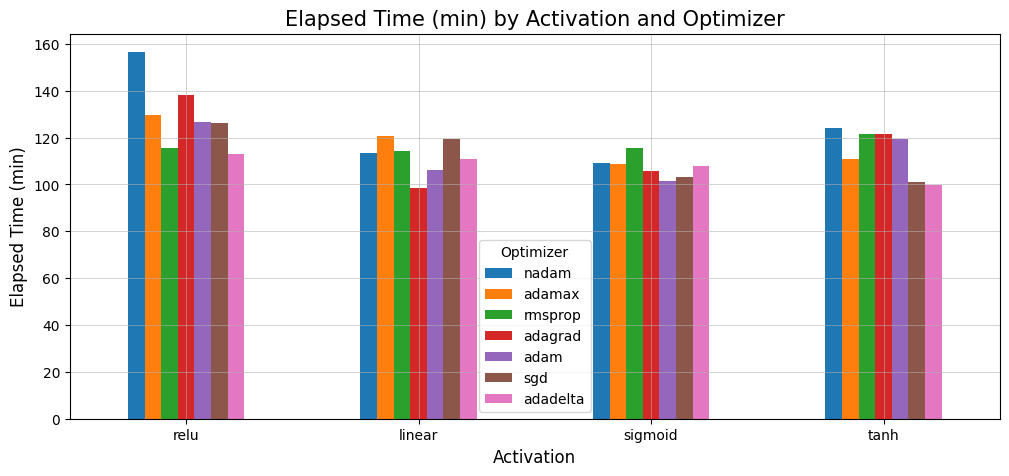

In [127]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

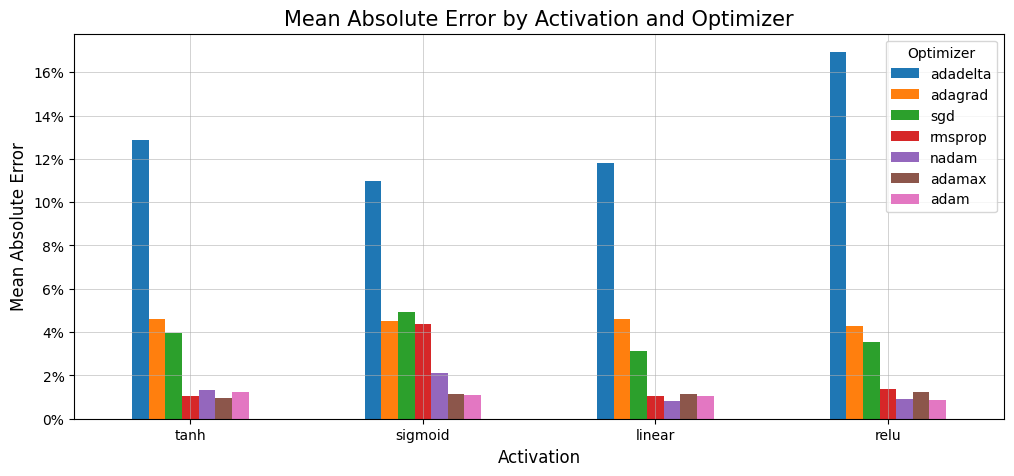

In [128]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

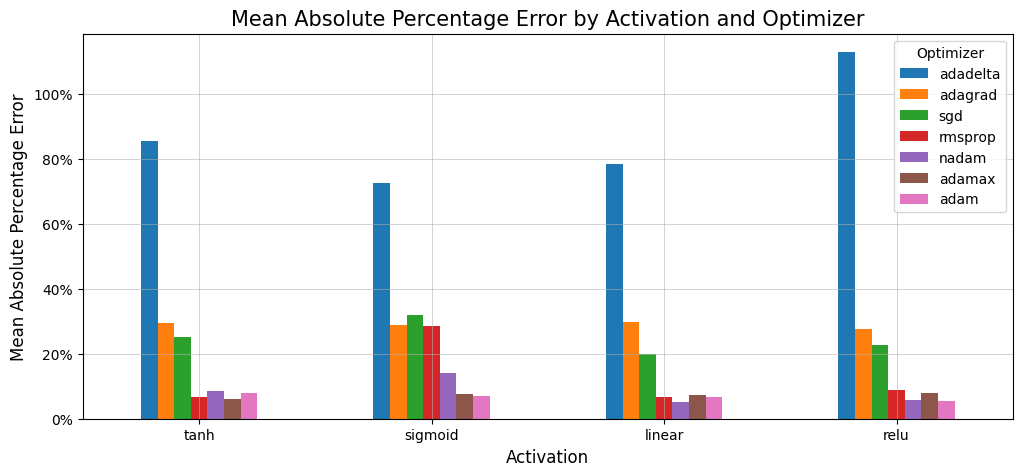

In [129]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

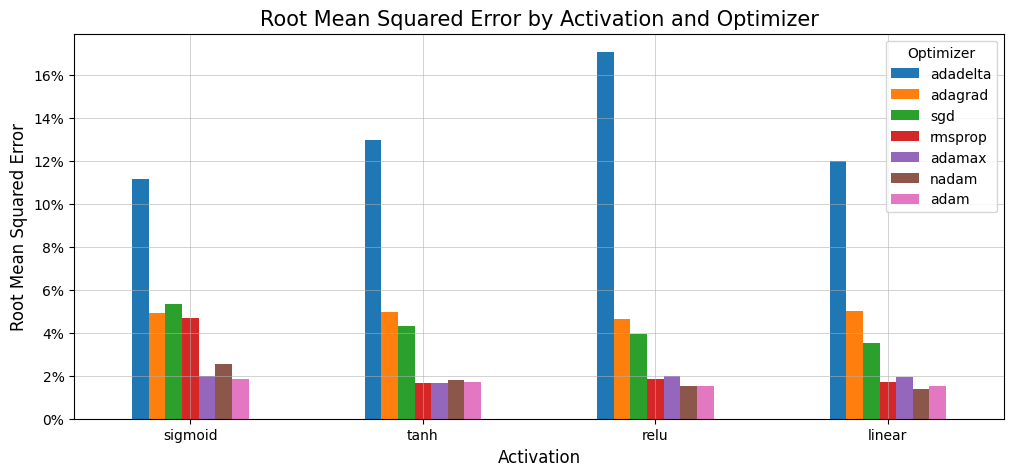

In [130]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

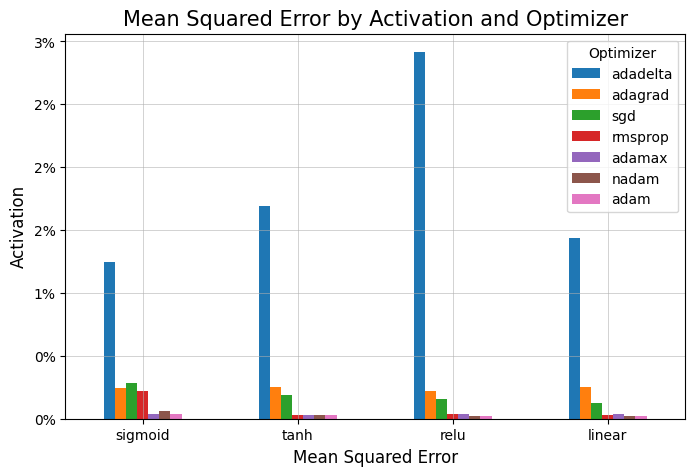

In [135]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

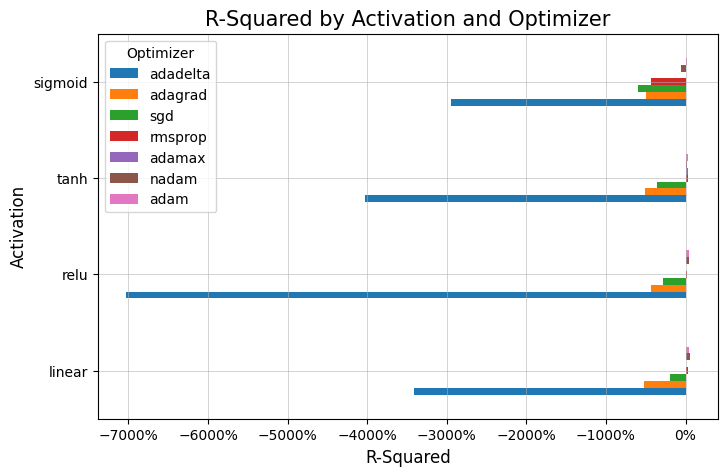

In [141]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()